In [23]:
import pandas as pd
import os
import seaborn as sns

folder = "results"
systems = ['mistral', 'gemma', 'llama', 'gpt3.5', 'gpt4', '300']

models = "_".join(systems)
final_path = os.path.join(folder,models)
df = pd.read_csv(final_path)
# clean undesired columns
df = df.drop(['Unnamed: 0'], axis=1)
df = df.drop(['Unnamed: 0.1'], axis=1)
df


responsible for others  responsible for myself  motivation  \
0                         3.0                     4.0         2.0   
1                         3.0                     4.0         2.0   
2                         3.0                     4.0         2.0   
3                         4.0                     3.0         2.0   
4                         3.0                     4.0         3.0   
...                       ...                     ...         ...   
14995                     2.0                     3.0         2.0   
14996                     3.0                     2.0         2.0   
14997                     3.0                     2.0         2.0   
14998                     3.0                     2.0         3.0   
14999                     3.0                     2.0         2.0   

                    system   culture  \
0      mistral-7b-instruct        us   
1      mistral-7b-instruct        us   
2      mistral-7b-instruct        us   
3      mistral-7b-instruct        us   
4      mistral-7b-instruct        us   
...                    ...       ...   
14995  gpt-4-turbo-preview  japanese   
14996  gpt-4-turbo-preview  japanese   
14997  gpt-4-turbo-preview  japanese   
14998  gpt-4-turbo-preview  japanese   
14999  gpt-4-turbo-preview  japanese   

                                               situation        status  
0      You receive a stellar performance review and a...  self-success  
1      After a challenging match, you win first place...  self-success  
2      ]You audition for a play and secure the lead r...  self-success  
3      In a group project, you receive an A grade, wh...  self-success  
4      Your artwork receives widespread praise and se...  self-success  
...                                                  ...           ...  
14995  あなたは職場で高評価を受け、その結果、昇進につながり、幸せに感じます。しかし、       ...  self-success  
14996  強い相手と対戦したのですがあなたは、で優勝し、嬉しく感じます。一方、チームメートは苦戦し、 ...  self-success  
14997  「あなたは演劇のオーディションを受け、主役ーに選ばれ、最高に嬉しい気分になっています。   ...  self-success  
14998  グループプロジェクトでAの成績を受け取り、最高に嬉しく感じています。しかし、        ...  self-success  
14999  あなたの芸術作品は多くの人々から賞賛を受け、展示会での売れ行きも上々で、達成感を感じています...  self-success  

[15000 rows x 7 columns]

In [24]:
import random
import pandas as pd
from statsmodels.stats.weightstats import ttest_ind
from collections import defaultdict
import sys

p_vals_per_n = defaultdict(lambda: defaultdict(list))

# per emotion in stype within a system find n where t-test indicates same distribution
emotion_dict = {'self-success':['motivation', 'responsible for others','fear_happiness', 'positive_negative'],\
                'self-failure': ['motivation', 'responsible for myself', 'responsible for others']}
emotion_dict = {'self-success':['motivation', 'responsible for others'],\
                'self-failure': ['motivation', 'responsible for myself', 'responsible for others']}
systems = ["mistral-7b-instruct", "gemma-7b-it:free", "llama-2-70b-chat", "gpt-3.5-turbo", "gpt-4-turbo-preview"]
#emotion_dict = {'self-success':['motivation', 'responsible for others']}
samples = range(300)
relation = "two-sided"
for system in systems:
    # extract system's samples
    one = df[df['system']==system]
    # split df to two different poulations us and jp
    us = one[one['culture']=="us"]
    us = us.reset_index()
    jp = one[one['culture']=="japanese"]
    jp = jp.reset_index()
    for stype in emotion_dict.keys():
        stype_df_us = us[us['status']==stype]
        stype_df_jp = jp[jp['status']==stype]
        for emotion in emotion_dict[stype]:
            for n in range(10, 300, 10):
                repeats_us = [] # a list of dataframes of n size
                repeats_jp = [] # a list of dataframes of n size
                for repeat in range(20):
                    # draw n
                    indecies = random.sample(samples, n)
                    us_sample = pd.DataFrame()
                    jp_sample = pd.DataFrame()
                    for index in indecies:
                        # grab the samples by their indecies (10 lines)
                        jp_mini = stype_df_jp.iloc[index*10:index*10+10, :]
                        jp_sample = pd.concat([jp_sample, jp_mini])
                        us_mini = stype_df_us.iloc[index*10:index*10+10, :]
                        us_sample = pd.concat([us_sample, us_mini])                    
                    emotion_us = jp_sample[emotion]
                    emotion_jp = us_sample[emotion]
                    repeats_us.append(emotion_us)
                    repeats_jp.append(emotion_jp)
                #print(len(repeats_us))
                #print(n)
                for i, (emotion_us1, emotion_jp1) in enumerate(zip(repeats_us, repeats_jp)):
                    for j, (emotion_us2, emotion_jp2) in enumerate(zip(repeats_us, repeats_jp)):
                        if i == j: # don't compare same data
                           continue
                        #print("passed")
                        # test for similarity
                        _, pvalue1, _ = ttest_ind(emotion_us1, emotion_us2, alternative=relation)
                        p_vals_per_n["us_"+emotion+"_"+stype+"_"+system][n]+=[pvalue1]
                        _, pvalue2, _ = ttest_ind(emotion_jp1, emotion_jp2, alternative=relation)
                        p_vals_per_n["jp_"+emotion+"_"+stype+"_"+system][n]+=[pvalue2]                            
print(p_vals_per_n)
                                  
# plot average p_values per n per system

/Users/shirandudy/miniconda3/envs/cultural_rep/lib/python3.12/site-packages/statsmodels/stats/weightstats.py:135: RuntimeWarning: invalid value encountered in scalar divide
  return self.sum / self.sum_weights
/Users/shirandudy/miniconda3/envs/cultural_rep/lib/python3.12/site-packages/statsmodels/stats/weightstats.py:999: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(var_pooled * (1.0 / d1.nobs + 1.0 / d2.nobs))
/Users/shirandudy/miniconda3/envs/cultural_rep/lib/python3.12/site-packages/statsmodels/stats/weightstats.py:999: RuntimeWarning: invalid value encountered in scalar multiply
  return np.sqrt(var_pooled * (1.0 / d1.nobs + 1.0 / d2.nobs))
/Users/shirandudy/miniconda3/envs/cultural_rep/lib/python3.12/site-packages/statsmodels/stats/weightstats.py:135: RuntimeWarning: invalid value encountered in scalar divide
  return self.sum / self.sum_weights
/Users/shirandudy/miniconda3/envs/cultural_rep/lib/python3.12/site-packages/statsmodels/stats/weightstats

defaultdict(<function <lambda> at 0x17ab739c0>, {'us_motivation_self-success_mistral-7b-instruct': defaultdict(<class 'list'>, {10: [0.513814178626087, 0.7328437981562346, 0.14495076302184678, 0.37669002829006526, 0.6355602920349284, 0.5946691923647982, 0.735732125870662, 0.11489713444701982, 0.43371404749376263, 0.5829628893001356, 0.39695006163457747, 0.7418291920082307, 0.2745890382505703, 0.6602123985271378, 0.8649269458517426, 0.3963919180175215, 0.22869486695466218, 0.394167856643895, 0.9038302100809391, 0.513814178626087, 0.31485098818991486, 0.036366965896941966, 0.14528031021107032, 0.29661653389891274, 0.22319713477530634, 0.3229998441984919, 0.02410666571884046, 0.16176744562997447, 0.24060264786354693, 0.8274038306719411, 0.3481443577368081, 0.09249916426410291, 0.3191665994418487, 0.6809407605244022, 0.14049056695951323, 0.06255088549191633, 0.1297241838753712, 0.5069257337281412, 0.7328437981562346, 0.31485098818991486, 0.283117302610841, 0.5832818665593725, 0.87655206176

/Users/shirandudy/miniconda3/envs/cultural_rep/lib/python3.12/site-packages/statsmodels/stats/weightstats.py:135: RuntimeWarning: invalid value encountered in scalar divide
  return self.sum / self.sum_weights
/Users/shirandudy/miniconda3/envs/cultural_rep/lib/python3.12/site-packages/statsmodels/stats/weightstats.py:999: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(var_pooled * (1.0 / d1.nobs + 1.0 / d2.nobs))
/Users/shirandudy/miniconda3/envs/cultural_rep/lib/python3.12/site-packages/statsmodels/stats/weightstats.py:999: RuntimeWarning: invalid value encountered in scalar multiply
  return np.sqrt(var_pooled * (1.0 / d1.nobs + 1.0 / d2.nobs))
/Users/shirandudy/miniconda3/envs/cultural_rep/lib/python3.12/site-packages/statsmodels/stats/weightstats.py:135: RuntimeWarning: invalid value encountered in scalar divide
  return self.sum / self.sum_weights
/Users/shirandudy/miniconda3/envs/cultural_rep/lib/python3.12/site-packages/statsmodels/stats/weightstats

In [25]:
# make a dataframe
emotion_dict = {'self-success':['motivation', 'responsible for others'],\
                'self-failure': ['motivation', 'responsible for myself', 'responsible for others']}
frames = pd.DataFrame(columns=["system", "p_value", "n"])
culture = "us"
i = 0 
for system in systems:
    n_samples = p_vals_per_n[culture+"_"+emotion+"_"+stype+"_"+system].keys()
    for n in n_samples:
        for stype in emotion_dict.keys(): #emotion_dict.keys():
            for emotion in emotion_dict[stype]: #motivation
                for p_value in p_vals_per_n[culture+"_"+emotion+"_"+stype+"_"+system][n]:
                    #p_vals_per_n[culture+"_"+emotion+"_"+stype+"_"+system][n] = [sum(p_vals_per_n[culture+"_"+emotion+"_"+stype+"_"+system][n]) / len(p_vals_per_n[culture+"_"+emotion+"_"+stype+"_"+system][n])]
                    frames.loc[i, "system"] = system
                    frames.loc[i, "p_value"] = p_value
                    frames.loc[i, "n"] = n
                    i+=1
                    #print(n)
                    #frames.loc[n,system] = p_vals_per_n[culture+"_"+emotion+"_"+stype+"_"+system][n]
                #frames.loc[n,system] = p_vals_per_n[culture+"_"+emotion+"_"+stype+"_"+system][n][0]

            #    p_vals_per_n
            #frames.loc[n,system] = sum(p_vals_per_n[system][n]) / len(p_vals_per_n[system][n])
        # plot the graphs
frames


system   p_value    n
0       mistral-7b-instruct  0.513814   10
1       mistral-7b-instruct  0.732844   10
2       mistral-7b-instruct  0.144951   10
3       mistral-7b-instruct   0.37669   10
4       mistral-7b-instruct   0.63556   10
...                     ...       ...  ...
275495  gpt-4-turbo-preview       NaN  290
275496  gpt-4-turbo-preview       NaN  290
275497  gpt-4-turbo-preview       NaN  290
275498  gpt-4-turbo-preview       NaN  290
275499  gpt-4-turbo-preview       NaN  290

[275500 rows x 3 columns]

In [27]:
# aggregate 'motivation'
systems = ["mistral-7b-instruct", "gemma-7b-it:free", "llama-2-70b-chat", "gpt-3.5-turbo", "gpt-4-turbo-preview"]
motivation = pd.DataFrame(columns=systems, index=range(10, 300, 10))
for system in systems:
    for n in range(10, 300, 10):
        system_df = frames[frames["system"]==system]
        #motivation.loc[n,system] = system_df[system_df["n"]==n].p_value.mean()
        motivation.loc[n,system] = system_df[system_df["n"]==n].p_value.median()

        #print(f'n={n} {system_df[system_df["n"]==n].p_value.median()}')

motivation


mistral-7b-instruct gemma-7b-it:free llama-2-70b-chat gpt-3.5-turbo  \
10             0.492843          0.54039         0.634356      0.473303   
20             0.518601         0.623031         0.611285      0.470744   
30             0.583026          0.60202         0.482609      0.540827   
40             0.475846         0.617033         0.536644      0.560957   
50              0.47614         0.589513         0.679514      0.507953   
60             0.536005          0.59464         0.561123      0.554754   
70             0.525492         0.646073         0.578922      0.473117   
80             0.578507         0.549426         0.611194       0.54711   
90             0.516234         0.621557         0.651703       0.58599   
100            0.652187         0.590055         0.653567      0.558682   
110            0.609654         0.647549         0.666623      0.645897   
120            0.581322         0.668693          0.59274      0.606808   
130            0.610724         0.670209         0.617506      0.583618   
140             0.73988         0.587218         0.675939      0.538371   
150            0.598399         0.664327         0.551432       0.61914   
160             0.59502         0.713285         0.744257       0.66316   
170            0.678189          0.63106         0.670536      0.684407   
180            0.739396         0.722565         0.706492      0.737139   
190            0.662147         0.694564         0.686087      0.620801   
200            0.754871         0.675452         0.778305      0.621885   
210            0.692581         0.784272          0.75247      0.670262   
220            0.697947         0.849971         0.679982      0.658821   
230            0.759623         0.723636         0.828523      0.737726   
240             0.75992         0.716404         0.766536      0.780594   
250            0.792686         0.823793         0.738888      0.698385   
260            0.709241          0.80869         0.865139      0.802745   
270            0.777206         0.839797          0.87247      0.753885   
280            0.857646         0.862904         0.877783      0.870092   
290            0.882274         0.909736         0.904391      0.894096   

    gpt-4-turbo-preview  
10             0.632959  
20             0.630856  
30             0.721093  
40             0.752516  
50             0.648444  
60             0.639076  
70             0.689932  
80             0.765798  
90             0.680967  
100            0.710103  
110            0.695698  
120            0.743525  
130             0.73543  
140            0.701107  
150            0.757406  
160            0.778281  
170            0.830345  
180            0.781156  
190            0.774134  
200             0.81351  
210            0.838266  
220            0.836355  
230            0.790022  
240            0.850944  
250            0.896121  
260            0.864116  
270            0.898246  
280            0.905443  
290            0.948727

In [42]:
# make a dataframe for motivation
emotion_dict = {'self-success':['motivation', 'responsible for others'],\
                'self-failure': ['motivation', 'responsible for myself', 'responsible for others']}
frames_j = pd.DataFrame(columns=["system", "p_value", "n"])
culture = "jp"
i = 0 
for system in systems:
    n_samples = p_vals_per_n[culture+"_"+emotion+"_"+stype+"_"+system].keys()
    for n in n_samples:
        for stype in emotion_dict.keys(): #emotion_dict.keys():
            for emotion in emotion_dict[stype]: #motivation
                for p_value in p_vals_per_n[culture+"_"+emotion+"_"+stype+"_"+system][n]:
                    #p_vals_per_n[culture+"_"+emotion+"_"+stype+"_"+system][n] = [sum(p_vals_per_n[culture+"_"+emotion+"_"+stype+"_"+system][n]) / len(p_vals_per_n[culture+"_"+emotion+"_"+stype+"_"+system][n])]
                    frames_j.loc[i, "system"] = system
                    frames_j.loc[i, "p_value"] = p_value
                    frames_j.loc[i, "n"] = n
                    i+=1

frames_j


system   p_value    n
0       mistral-7b-instruct  0.456116   10
1       mistral-7b-instruct  0.209049   10
2       mistral-7b-instruct  0.383658   10
3       mistral-7b-instruct  0.225587   10
4       mistral-7b-instruct  0.302083   10
...                     ...       ...  ...
275495  gpt-4-turbo-preview       NaN  290
275496  gpt-4-turbo-preview       NaN  290
275497  gpt-4-turbo-preview       NaN  290
275498  gpt-4-turbo-preview       NaN  290
275499  gpt-4-turbo-preview       NaN  290

[275500 rows x 3 columns]

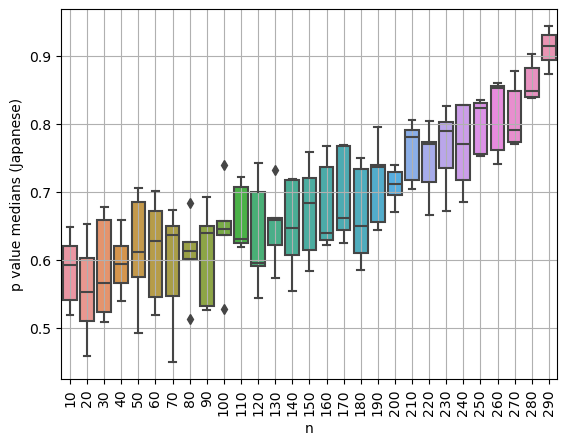

In [44]:
# plot
motivation = pd.DataFrame(columns=["system", "p_value", "n"])
systems = ["mistral-7b-instruct", "gemma-7b-it:free", "llama-2-70b-chat", "gpt-3.5-turbo", "gpt-4-turbo-preview"]

i = 0 
for system in systems:
    system_df = frames_j[frames_j["system"]==system]
    for n in range(10, 300, 10):
        motivation.loc[i, "system"] = system
        motivation.loc[i, "p value medians (Japanese)"] = system_df[system_df["n"]==n].p_value.mean()
        motivation.loc[i, "n"] = n
        i+=1

ax = sns.boxplot(x='n', y='p value medians (Japanese)', data=motivation)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.yaxis.grid(True)
ax.xaxis.grid(True)
plt.savefig("results/japanese_medians.pdf", format='pdf')